In [1]:
import glob
import numpy as np
import matplotlib.pylab as plt

from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
import cooltools
import cooltools.lib.plotting
import pandas as pd
import h5py 
import os
import h5py 
import time
import sys
import seaborn as sns
import warnings

import ast

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


In [2]:
# files

In [3]:
path_dict = {}

directory='/scratch1/rahmanin/target_loading_cohesin/target/target_domain_sites/sims_chn_epyc/'

for fname in glob.glob(directory+'folder*'):
    path_dict[fname.split('sims_chn_epyc/')[1][:]]= fname
path_dict = dict(sorted(path_dict.items()))
print(len(path_dict))

120


In [30]:
window_size = 1
numx,numy = 1,len(path_dict)
rep = 1 
mon = 1000
site = 10
deltactcf = 100
base_loading = 0.0001
birth = 0.01
total_sites = 10000
basetime = 200000
target_site_num = int(deltactcf)
density_multiplier = 1 + (((target_site_num * birth - base_loading)/base_loading)/total_sites)

folder_face_1.0_back_0_Clife_17.0_Cof_17.0_life_66_slife_66_birth_0.0005_targetsnum_1_deltactcf_1000_pause_0_sep_74_site_10_monomer_1000_replica_1_steps_200_vel_1
ratio for peak is 5.161736623944726


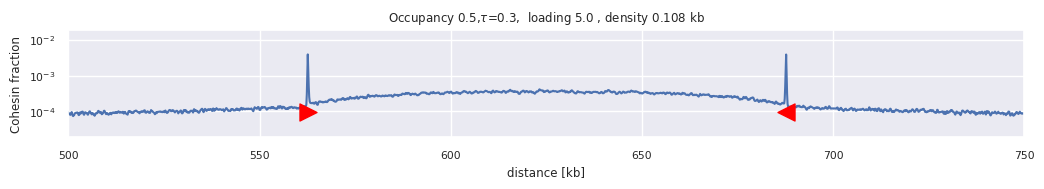

folder_face_1.0_back_0_Clife_17.0_Cof_17.0_life_66_slife_66_birth_0.0005_targetsnum_1_deltactcf_100_pause_0_sep_74_site_10_monomer_1000_replica_1_steps_200_vel_1
ratio for peak is 1.6213277415773781


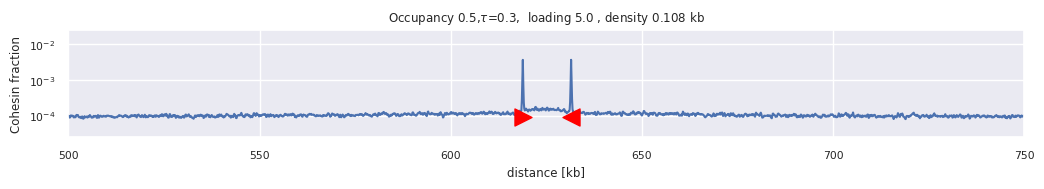

In [32]:
hist_dict = {}
c=1
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, targetsnum, deltactcf, pause, sep, site, mon, rep, step, vel = params

    c+=1
    if cof==17 and (deltactcf==1000 or deltactcf==100) and birth==0.0005:
        print(name)
        mapN=mon*site
        lefs = h5py.File(directory+name+'/LEFPositions.h5','r')["positions"]
        lef_lefts = lefs[basetime:,:,0].flatten()
        lef_rights = lefs[basetime:,:,1].flatten()
        ctcfrightlist = np.array(h5py.File(directory+name+'/LEFPositions.h5','r')['CTCF_sites_right'])
        ctcfleftlist = np.array(h5py.File(directory+name+'/LEFPositions.h5','r')['CTCF_sites_left'])
        lst = np.array(list(ctcfrightlist))# + list(ctcfleftlist))
        ### list of boundary elements on all replications
        lst_t = []
        for i in range(rep):
            lst_t += list(np.array(lst))
        
        lef_positions = np.hstack((lef_lefts,lef_rights))
        base_loading = 0.001
        density_multiplier = 1 + (((birth-base_loading)/base_loading)/total_sites)
        sep /= density_multiplier
        
        plt.figure(figsize = (10.5,1.95))
        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
        ran = np.arange(630-deltactcf//20,630+deltactcf//20, 10)
        #plt.scatter(ran, np.zeros(len(ran))+0.0001, marker='P', color='orange', s=150)
        plt.plot(np.arange(len(a))*0.125,a/np.sum(a), label=name)
        loading_rate = (np.sum(a[4995:5005])/np.sum(a[7995:8005]))
        print('ratio for peak is %s'%loading_rate)
        plt.scatter(ctcfrightlist*0.125,np.zeros(len(ctcfrightlist))+0.000095,marker='<',color='red',s=150,zorder=3)
        plt.scatter(ctcfleftlist*0.125,np.zeros(len(ctcfleftlist))+0.000095,marker='>',color='red',s=150,zorder=3)
        plt.xlim(500, 750)
        plt.grid(True)
        hist_dict[name] = a/np.sum(a)
        plt.ylabel('Cohesin fraction')
        plt.yscale('log')
        plt.xlabel('distance [kb]')
        plt.title(r'Occupancy 0.5,$\tau$=%s,  loading %s , density %s kb'%(np.round(clife/50,1), np.round(birth/0.0001), np.round(1/(sep*0.125),3)))
        
        plt.tight_layout()
        plt.show()


In [5]:
# Analysis for peak ratio

In [21]:
file = pd.read_csv('data/peakratio_target_respoints_w1_main_tau17_3_per_100k_epycs_around_both_new.csv') 
file['birthp']=(file['birth']/0.0001).astype(int)
file['deltactcf']=file['deltactcf']*0.125
new_file = file
ref_frip = new_file[(new_file['birthp']==1)&(new_file['deltactcf']==125.0)]['peakratio']
file = file[['birthp', 'deltactcf','peakratio']]
file['peakratio']=file['peakratio'].round(3)
file = file.query('birthp<=100 and deltactcf<125')
#file
referencepoint=file[(file['birthp']==1)&(file['deltactcf']==1)]['peakratio'].iloc[0]
file['peakrationorm']=file['peakratio']/referencepoint

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


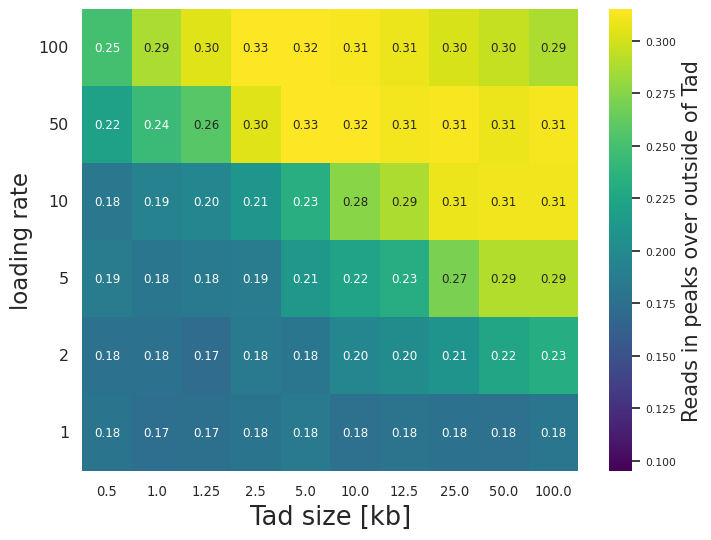

In [22]:
heatmap_data = file.pivot('birthp', 'deltactcf', 'peakratio')

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='1.2f',vmin=0.095,vmax=0.3151, cbar_kws={'label': 'Frip score'} )
sns.set(font_scale=0.71)
cbar = im.collections[0].colorbar
cbar.set_label('Reads in peaks over outside of Tad', fontsize=15)
plt.xlabel(r'Tad size [kb]', fontsize = 18.5)
plt.xticks(fontsize =9.51)
#plt.title(r'proc=%s kb,  $\tau_b$/$\tau_E$=%s, Occup = %s, density= 1/%s kb'%(life*5, np.round(clife/life,1),np.round(clife/(clife+cof_val),1), sep_vals*2.5), fontsize = 11)
plt.ylabel(r'loading rate', fontsize =16.5)
plt.yticks(fontsize=11.5, rotation=0)
plt.gca().invert_yaxis()
plt.savefig('figures/loading_rate_vs_tad_birth.png')
plt.show()

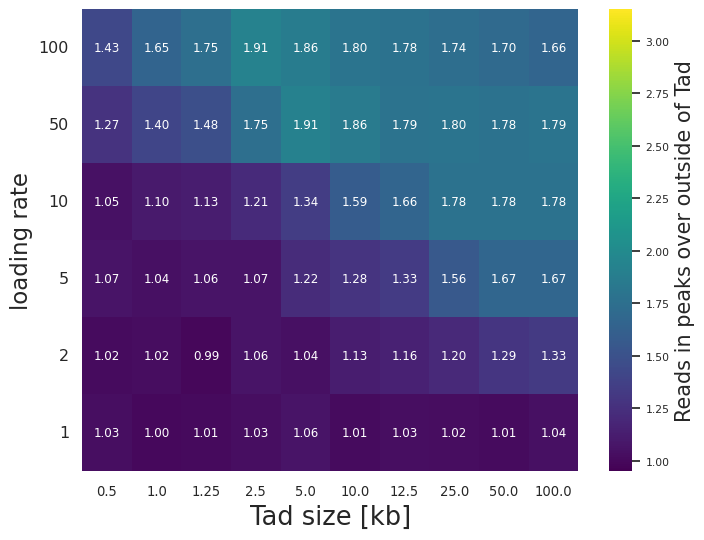

In [25]:
heatmap_data = file.pivot('birthp', 'deltactcf', 'peakrationorm')

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='1.2f',vmin=0.95,vmax=3.151, cbar_kws={'label': 'Frip score'} )
sns.set(font_scale=0.71)
cbar = im.collections[0].colorbar
cbar.set_label('Reads in peaks over outside of Tad', fontsize=15)
plt.xlabel(r'Tad size [kb]', fontsize = 18.5)
plt.xticks(fontsize =9.51)
#plt.title(r'proc=%s kb,  $\tau_b$/$\tau_E$=%s, Occup = %s, density= 1/%s kb'%(life*5, np.round(clife/life,1),np.round(clife/(clife+cof_val),1), sep_vals*2.5), fontsize = 11)
plt.ylabel(r'loading rate', fontsize =16.5)
plt.yticks(fontsize=11.5, rotation=0)
plt.gca().invert_yaxis()
plt.savefig('figures/loading_rate_vs_tad_birth.png')
plt.show()